##**HOMEWORK 08**
###**GANs**
### IANNWTF
###Group 02

In [4]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from IPython import display
import time 
# print(tf.__version__)


#**Load data**

In [5]:
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

Let's explore the data by doing some usefull prints.

##**Normalization and Input pipeline**

We will use the folowwing function to normalize, create our input pipeline and save some normalized images for later visualization.

In [12]:
def input_pipeline(images):
  # 1. Normalize the images to be between 0 and 1
  train_images = tf.image.convert_image_dtype(images, tf.float32)
  # 2. Create a tf.dataset from a train tensor images
  train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
  # expand the dimensions of the images.
  train_dataset = train_dataset.map(lambda img : tf.cast(tf.expand_dims(img,-1), tf.float32))

 
  
  # futher preprocessing 
  train_dataset = train_dataset.shuffle(buffer_size=128)
  train_dataset = train_dataset.batch(32)
  train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


  return train_dataset

In [14]:
# Only images for training 
train_dataset= input_pipeline(train_images)


# check the sizes and dimensions of the images
for i in train_dataset:
  print(f'min = {np.min(i)} \nmax = {np.max(i)} \nshape = {i.shape}, \ntype = {i.dtype}')
  break

min = 0.0 
max = 1.0 
shape = (32, 28, 28, 1), 
type = <dtype: 'float32'>


#**1. Building the Generative Adversarial Network (GAN)**

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

# THE DISCRIMINATOR
# Using two layers for reducing the size with a normal convolutional layer and dropout in between
class Discriminator(Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.reduce1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3,
                                          strides=(2,2),
                                          padding = 'same',
                                          activation=None,
                                          input_shape=(28,28,1)
                                          )
    self.dropout1 = tf.keras.layers.Dropout(rate=0.3)
    self.conv = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                          strides=(1,1),
                                          padding = 'same',
                                          activation=None)
    self.dropout2 = tf.keras.layers.Dropout(rate=0.3)
    self.reduce2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                          strides=(2,2),
                                          padding = 'same',
                                          activation=None)
    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.out = tf.keras.layers.Dense(1, activation='sigmoid')

    self.relu = tf.nn.leaky_relu

  @tf.function
  def call(self, x):
    x = self.reduce1(x)
    x = self.relu(x)
    x = self.dropout1(x)
    x = self.conv(x)
    x = self.relu(x)
    x = self.dropout2(x)
    x = self.reduce2(x)
    x = self.relu(x)
    x = self.global_pool(x)
    x = self.out(x)
    return x

In [16]:
# THE GENERATOR
# using two normal convolutional layers and a dropout layer with two upsamling layers in between.
class Generator(Model):
  def __init__(self, latent_dim):
    self.latent_dim = latent_dim
    super(Generator, self).__init__()
    n_nodes = latent_dim * 7 *7

    self.first = tf.keras.layers.Dense(n_nodes, input_dim = latent_dim, activation=None)
    self.batch_n1 = tf.keras.layers.BatchNormalization()

    self.reshape = tf.keras.layers.Reshape((7,7,latent_dim))
    #shape is now (7,7,100)

    self.conv1 = tf.keras.layers.Conv2D(filters=100, kernel_size=3, 
                                          padding = 'same',
                                          activation=None
                                          )
    self.batch_n2 = tf.keras.layers.BatchNormalization()
    self.dropout1 = tf.keras.layers.Dropout(rate=0.3)
    self.upsampling1 = tf.keras.layers.UpSampling2D((2,2))
    
    self.conv2 = tf.keras.layers.Conv2D(filters=100, kernel_size=3, 
                                          padding = 'same',
                                          activation=None
                                          )
    self.batch_n3 = tf.keras.layers.BatchNormalization()
    self.dropout2 = tf.keras.layers.Dropout(rate=0.3)
    self.conv3 = tf.keras.layers.Conv2D(filters=100, kernel_size=3,
                                          padding = 'same',
                                          activation=None
                                          )
    self.upsampling2 = tf.keras.layers.UpSampling2D((2,2))
    self.out = tf.keras.layers.Conv2D(filters=1, kernel_size=7,
                                          padding = 'same',
                                          activation='tanh'
                                          )
    self.relu = tf.nn.leaky_relu
  
  @tf.function
  def call(self, x, training=True):
    x = self.first(x)
    x = self.relu(x)
    x = self.batch_n1(x)
    x = self.reshape(x)
    x = self.conv1(x)
    x = self.relu(x)
    x = self.batch_n2(x)
    x = self.dropout1(x)
    x = self.upsampling1(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.batch_n3(x)
    x = self.dropout2(x)
    x = self.conv3(x)
    x = self.relu(x)
    x = self.upsampling2(x)
    x = self.out(x)
    return x

In [17]:
# Generate samples
num_samples = 32
# Dimensions
latent_dim = 100 

# Instantiate objects
generator = Generator(latent_dim=latent_dim)
discriminator = Discriminator()

###**Training the Convolutional Autoencoder**

In [18]:
# as specified in the tf documentation
#these functions calculate the loss for both generator and discriminator
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(data_set_output,gen_output):
    data_set_loss = cross_entropy(tf.ones_like(data_set_output), data_set_output)
    gen_loss = cross_entropy(tf.zeros_like(gen_output), gen_output)
    loss = data_set_loss + gen_loss
    return loss

def generator_loss(gen_output):
  return cross_entropy(tf.ones_like(gen_output), gen_output)

In [19]:
# adaptep from the tf documentation
def train_step(input,optimizer_generator,optimizer_discriminator):
  noise = tf.random.normal([num_samples, latent_dim])
  with tf.GradientTape() as tape_generator,tf.GradientTape() as tape_discriminator:
    
    #contain generated images returned by the generator
    gen_images=generator(noise)
    #contains the output after having proccesed one of the images from the dataset

    data_set_output=discriminator(input)
    gen_output=discriminator(gen_images)

    generator_l= generator_loss(gen_output)
    discriminator_l=discriminator_loss(data_set_output,gen_output )

  gradients_generator = tape_generator.gradient(generator_l, generator.trainable_variables)
  gradients_discriminator = tape_discriminator.gradient(discriminator_l, discriminator.trainable_variables)

  optimizer_generator.apply_gradients(zip(gradients_generator, generator.trainable_variables))
  optimizer_discriminator.apply_gradients(zip(gradients_discriminator, discriminator.trainable_variables))

  # retrieve losses
  return generator_l, discriminator_l

In [20]:
# Plot training and test loss.
def plot_loss(train_losses,test_losses):
  plt.figure()
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.title(f'Total test loss: {np.min(test_losses)}')
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend((line1,line2),("training","test"))
  plt.show()

In [21]:
# adapted from the tf documentation
def generate_and_save_images(model, epoch, test_input):
  
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):

    plt.subplot(len(test_input)/4, len(test_input)/4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.show()


Epoch: _15


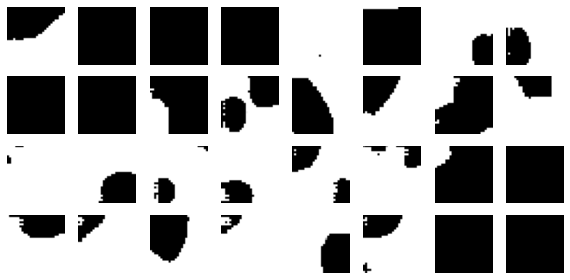

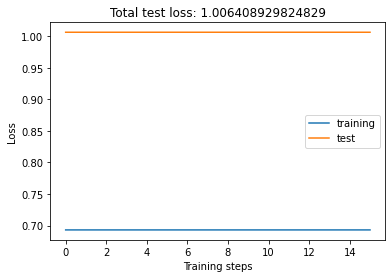


This training took: 15 minutes and 4.520409345626831 seconds.


In [23]:
import time
tf.keras.backend.clear_session()
### Hyperparameters
num_epochs = 15
learning_rate = 0.001
optimizer_generator=tf.keras.optimizers.Adam(learning_rate)
optimizer_discriminator=tf.keras.optimizers.Adam(learning_rate)

seed = tf.random.normal([num_samples, latent_dim])


# Set the time
start = time.time()

generator_losses = []
discriminator_losses = []
for epoch in range(0, num_epochs + 1):

    for input in train_dataset:
      generator_l, discriminator_l = train_step(input,optimizer_generator,optimizer_discriminator)
    generator_losses.append(generator_l)
    discriminator_losses.append(discriminator_l)
      
    # Clear after new epoch
    display.clear_output(wait=True)
    print(f'Epoch: _{epoch}')
    generate_and_save_images(generator, epoch +1, seed)
    plot_loss(generator_losses, discriminator_losses)


    

# Keep track of the time 
end = time.time()
duration = end - start

print(f'\nThis training took: {int (duration / 60)} minutes and {(duration % 60)} seconds.')